# Training models

This tutorial teaches you how to train models using OpenProtein.AI's
Property Regression models. These models can be used to make predictions for new sequence variants and to design libraries of optimized sequences.

## What you need before getting started

You need an uploaded dataset and assay object in order
to create training jobs. For more information, see [Uploading your data](./uploading-data.ipynb).

(Optional) You have to [create a prompt](../poet/creating-prompt.ipynb) to use our recommended PoET model.  
(Optional) [Fit an SVD](../foundation-models/SVD-embeddings.ipynb) on top of our embedding models for high fidelity custom-sized embeddings.

### Understanding Model Options
#### Embeddings
Embeddings capture essential patterns and relationships between protein sequences, shaping how the model interprets their properties. The recommended option is PoET, which generates embeddings tailored to specific fitness landscapes.
The following embedding models are available for use: 

- PoET (Recommended)
    - Conditional protein language model that enables embedding, scoring and generating sequences conditioned on an input protein family of interest.
    - You will be required to input a prompt if this option is selected. The prompt is used to guide the model predictions based on your family of interest that you have indicated in your prompt
    - Reduction type will be set to ‘None’ as the default
- Prot Seq
    - Masked protein language model (~300M parameters) trained on UniRef50 with contact and secondary structure prediction as secondary objectives. Use random Fourier position embeddings and FlashAttention to enable fast inference
- Rotaprot Large UniRef50w
    - Masked protein language model (~900M parameters) trained on UniRef100 with sequences weighted inversely proportional to the number of UniRef50 homologs. Uses rotary relative position embeddings and FlashAttention to enable fast inference.
- Rotaprot Large UniRef90 Finetuned
    - Rotaprot Large UniRef50W finetuned on UniRef100 with sequences weighted inversely proportional to the number of UniRef90 cluster members. 
- ESM1
    - Community based ESM1 models, with different versions having different model parameters and training data
    - Models include:
        - esm1b_t33_650M_UR50S
        - esm1v_t33_650M_UR90S_1
        - esm1v_t33_650M_UR90S_2
        - esm1v_t33_650M_UR90S_3
        - esm1v_t33_650M_UR90S_4
        - esm1v_t33_650M_UR90S_5
- ESM2
    - Community-based ESM2 models, with different versions having different model parameters and training data
    - Models include:
        - esm2_t8_50M_UR50D
        - esm2_t12_35M_UR50D
        - esm2_t30_150M_UR50D
        - esm2_t33_650M_UR50D
        - esm2_t36_3B_UR50D
- ProtTrans
    - Community-based ProtTrans models
    - Model include: 
        - prott5-xl

#### Reduction Type
The reduction type determines how the output embeddings are summarized into a more manageable form. This option helps control how the model compresses information, enabling the capture of relevant features from your protein sequences while reducing dimensionality. The available options are:

1. Mean

Creates a sequence embedding by averaging the per-residue embeddings over the length dimension. Useful for working with variable length sequences, but loses specific position information in the embedding compared with the full LxN embedding or SVD reduction thereof.

When to use: 
- Variable length sequence datasets when alignment is not a good option.
- Sometimes outperforms full embeddings on small or highly diverse datasets.

2. Sum

The same as the mean embedding except that per-residues embeddings are summed over the length dimension rather than averaged. This can better preserve length and domain multiplicity information but tends to underperform mean embeddings for most use cases. 

When to use:
- Variable length sequence datasets as an alternative to mean embeddings. Mean embeddings should generally be preferred, but they can be compared on a case-by-case basis.

3. None

Retains the full embeddings without any dimensionality reduction. This option captures the complete relationships between features, offering the most detailed representation at the cost of larger file sizes. Note that this differs from the web app where `None` refers to using SVDs instead.

Note: Using full-sized embeddings may be unstable on the platform at this stage.

When to use:
- Most substitution-only design projects should prefer this option. Tends to outperform mean embeddings when sequences are fixed length or can be aligned.
- Use when you require the full feature set for detailed analysis or downstream processing.


## Training a model

Use the assay object to create a training job:

In [ ]:
# Option 1 (Recommended): Use PoET with prepared prompt
predictor = session.embeddings.poet.fit_gp(assay=assay,
                                            properties=["isobutyramide_normalized_fitness"],
                                            name="mymodel", # name the resulting model
                                            prompt=prompt,
                                            reduction="MEAN")
# Option 2: Use prot-seq or any other model without prompt
# predictor = session.embeddings.prot_seq.fit_gp(assay=assay,
#                                                 properties=["isobutyramide_normalized_fitness"],
#                                                 name="mymodel", # name the resulting model
#                                                 reduction="MEAN")
# Option 3: Use a fitted SVD
# predictor = svd.fit_gp(assay=assay,
#                         properties=["isobutyramide_normalized_fitness"],
#                         name="mymodel") # name the resulting model
predictor_id = predictor.id
predictor

PredictorMetadata(id='ae2db820-59c8-4902-8e75-e2d5196c98ad', name='mymodel', description=None, status=<JobStatus.PENDING: 'PENDING'>, model_spec=ModelSpec(kernel=Kernel(type='RBF', multitask=False), constraints=None, features=Features(type=<FeatureType.PLM: 'PLM'>, model_id='poet', reduction='MEAN')), training_dataset=Dataset(assay_id='99dc46be-5fb1-4771-a59a-65ec76d70765', properties=['isobutyramide_normalized_fitness']))

In [ ]:
predictor.refresh()
predictor.status

<JobStatus.RUNNING: 'RUNNING'>

Wait for the results before proceeding:

In [ ]:
results = predictor.wait(verbose=False)

You can display your results as a scatterplot:

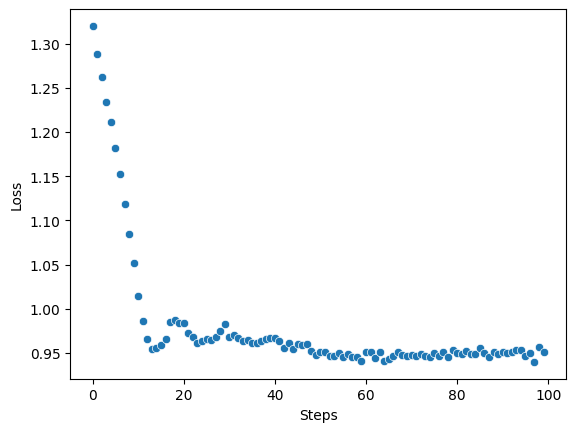

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=range(len(results[0].losses)), y=results[0].losses)
plt.xlabel("Steps")
plt.ylabel("Loss");

Request a cross-validation job to see the training results in more detail:

In [ ]:
cvjob = predictor.crossvalidate()
cvjob.status

<JobStatus.PENDING: 'PENDING'>

In [ ]:
cvdata = cvjob.wait(verbose=True)

Waiting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 252.60it/s, status=SUCCESS]


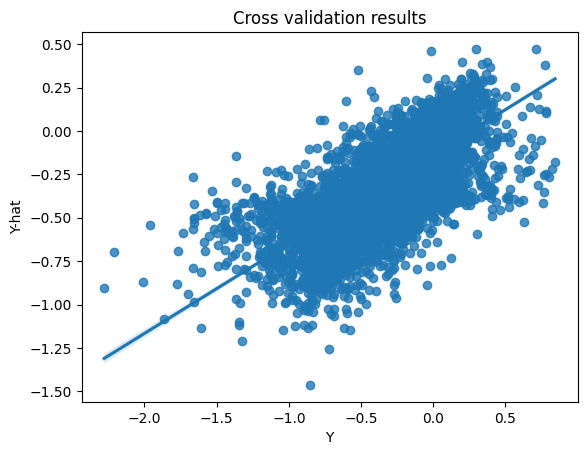

In [ ]:
ys, y_mus, y_vars = cvdata
sns.regplot(x=ys.astype(float), y=y_mus.astype(float))
plt.xlabel("Y")
plt.title("Cross validation results")
plt.ylabel("Y-hat");

# Retrieving old models
In order to retrieve and predict using older models trained with `session.train` (now `session.deprecated.train`), you will need to specify the train job id with `load_job`.

In [ ]:
train = session.load_job("6f8dd9a8-0370-4f3b-9ff6-43281a6f3428")
train

TrainJob(job_id='6f8dd9a8-0370-4f3b-9ff6-43281a6f3428', job_type=<JobType.workflow_train: '/workflow/train'>, status=<JobStatus.SUCCESS: 'SUCCESS'>, created_date=datetime.datetime(2024, 12, 2, 8, 42, 54, 93414), start_date=datetime.datetime(2024, 12, 2, 8, 42, 54, 160768), end_date=datetime.datetime(2024, 12, 2, 8, 46, 40, 984249), prerequisite_job_id='0de826f5-7202-4ac8-a947-c232bc3a0556', progress_message=None, progress_counter=None, sequence_length=None, traingraph=None)

You can list previous train jobs using `session.jobs.list` with `JobType.workflow_train`.

In [ ]:
from openprotein.schemas import JobType
train_jobs = session.jobs.list(job_type=JobType.workflow_train, limit=5)
train_jobs

[TrainJob(job_id='6f8dd9a8-0370-4f3b-9ff6-43281a6f3428', job_type=<JobType.workflow_train: '/workflow/train'>, status=<JobStatus.SUCCESS: 'SUCCESS'>, created_date=datetime.datetime(2024, 12, 2, 8, 42, 54, 93414), start_date=datetime.datetime(2024, 12, 2, 8, 42, 54, 160768), end_date=datetime.datetime(2024, 12, 2, 8, 46, 40, 984249), prerequisite_job_id='0de826f5-7202-4ac8-a947-c232bc3a0556', progress_message=None, progress_counter=None, sequence_length=None, traingraph=None),
 TrainJob(job_id='86addd0d-5939-4116-bc4d-45f03582a540', job_type=<JobType.workflow_train: '/workflow/train'>, status=<JobStatus.SUCCESS: 'SUCCESS'>, created_date=datetime.datetime(2024, 12, 2, 8, 19, 29, 555199), start_date=datetime.datetime(2024, 12, 2, 8, 23, 6, 269712), end_date=datetime.datetime(2024, 12, 2, 8, 41, 36, 398557), prerequisite_job_id='0de826f5-7202-4ac8-a947-c232bc3a0556', progress_message=None, progress_counter=None, sequence_length=None, traingraph=None),
 TrainJob(job_id='c5b8784f-b5b0-4083-b

Note that with `list`, you will still have to put that through `load_job` in order to load the model itself.

The model object is a more complex object (has `predict` method) and is thus not loaded when calling `list`.

In [ ]:
train = session.load_job(train_jobs[0].job_id)
train

TrainJob(job_id='6f8dd9a8-0370-4f3b-9ff6-43281a6f3428', job_type=<JobType.workflow_train: '/workflow/train'>, status=<JobStatus.SUCCESS: 'SUCCESS'>, created_date=datetime.datetime(2024, 12, 2, 8, 42, 54, 93414), start_date=datetime.datetime(2024, 12, 2, 8, 42, 54, 160768), end_date=datetime.datetime(2024, 12, 2, 8, 46, 40, 984249), prerequisite_job_id='0de826f5-7202-4ac8-a947-c232bc3a0556', progress_message=None, progress_counter=None, sequence_length=None, traingraph=None)

Finally you can also list models associated with an assay. These models are associated with a train job which can be loaded as before.

In [ ]:
train = session.load_job(assay.list_models()[0]["job_id"])
train

TrainJob(job_id='5d4de46c-293e-446e-bad7-297db00b7744', job_type=<JobType.workflow_train: '/workflow/train'>, status=<JobStatus.SUCCESS: 'SUCCESS'>, created_date=datetime.datetime(2024, 10, 3, 4, 4, 24, 879680), start_date=datetime.datetime(2024, 10, 3, 4, 10, 53, 104694), end_date=datetime.datetime(2024, 10, 3, 4, 12, 21, 940962), prerequisite_job_id='18acb4e2-b474-458c-8110-df4002e8fcbf', progress_message=None, progress_counter=None, sequence_length=None, traingraph=None)

## Next steps

Our [Predictor API](../api-reference/predictor.rst)
page contains more information about training your models.

You can use your trained model to perform a single site analysis or design sequences. See [Using single site analysis](./single-site-analysis.ipynb) and [Designing sequences](./designing-sequences.ipynb) for details.